# Grid algorithm for the beta-binomial hierarchical model

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [4]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [5]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [6]:
def decorate_heads(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of heads (k)')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    legend()

In [7]:
def decorate_proportion(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    legend()

## The Grid Algorithm

In [8]:
import numpy as np
from scipy.stats import gamma

alpha = 4
beta = 0.5

qs = np.linspace(0.1, 25, 100)
ps = gamma(alpha, scale=1/beta).pdf(qs)

In [9]:
from empiricaldist import Pmf

prior_alpha = Pmf(ps, qs)
prior_alpha.normalize()

prior_alpha.index.name = 'alpha'
prior_alpha.shape

(100,)

7.970910788849202

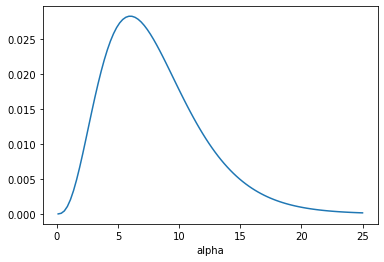

In [10]:
prior_alpha.plot()
prior_alpha.mean()

In [11]:
qs = np.linspace(0.1, 25, 90)
ps = gamma(alpha, scale=1/beta).pdf(qs)
prior_beta = Pmf(ps, qs)
prior_beta.normalize()

prior_beta.index.name = 'beta'
prior_beta.shape

(90,)

7.97105344479301

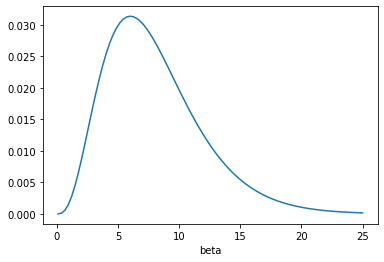

In [12]:
prior_beta.plot()
prior_beta.mean()

In [13]:
def make_hyper(prior_alpha, prior_beta):
    PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')
    hyper = PA * PB
    return hyper

hyper = make_hyper(prior_alpha, prior_beta)
hyper.shape

(100, 90)

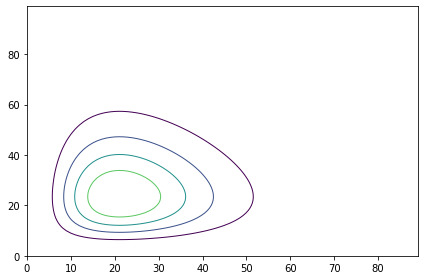

In [14]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(hyper))

## Make Prior

<AxesSubplot:>

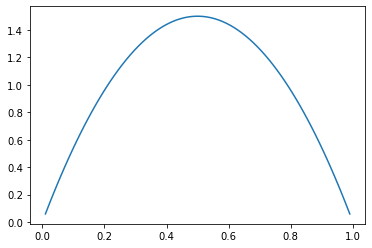

In [15]:
from scipy.stats import beta as betadist

xs = np.linspace(0.01, 0.99, 80)
prior_x = Pmf(betadist.pdf(xs, 2, 2), xs)
prior_x.plot()

In [16]:
from scipy.stats import beta as betadist

def make_prior(hyper, prior_alpha, prior_beta, xs):
    
    A, B, X = np.meshgrid(prior_alpha.qs, prior_beta.qs, xs, indexing='ij')
    ps = betadist.pdf(X, A, B)

    totals = ps.sum(axis=2)

    nc = hyper / totals

    shape = nc.shape + (1,)
    prior = ps * nc.reshape(shape)

    return prior

In [17]:
xs = np.linspace(0.01, 0.99, 80)
prior = make_prior(hyper, prior_alpha, prior_beta, xs)
prior.sum()

1.0000000000000007

In [18]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

7.970910788849203

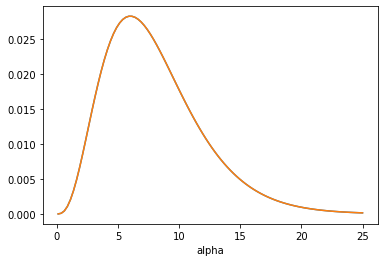

In [19]:
prior_a = Pmf(marginal(prior, 0), prior_alpha.qs)
prior_alpha.plot()
prior_a.plot()
prior_a.mean()

<AxesSubplot:xlabel='beta'>

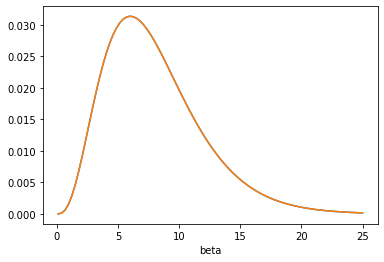

In [20]:
prior_b = Pmf(marginal(prior, 1), prior_beta.qs)
prior_beta.plot()
prior_b.plot()

<AxesSubplot:>

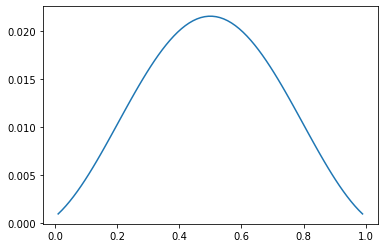

In [21]:
prior_x = Pmf(marginal(prior, 2), xs)
prior_x.plot()

## The Update

In [22]:
from scipy.stats import binom

n = 250
ks = 140
X, K = np.meshgrid(xs, ks)
like_x = binom.pmf(K, n, X).prod(axis=0)
like_x.shape

(80,)

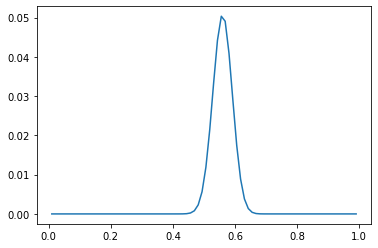

In [23]:
plt.plot(xs, like_x)

In [24]:
def update(prior, data):
    n, ks = data
    X, K = np.meshgrid(xs, ks)
    like_x = binom.pmf(K, n, X).prod(axis=0)

    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [25]:
data = 250, 140
posterior = update(prior, data)

0.5586974454638711

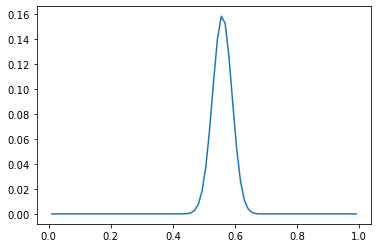

In [26]:
marginal_x = Pmf(marginal(posterior, 2), xs)
marginal_x.plot()
marginal_x.mean()

8.805918336878161

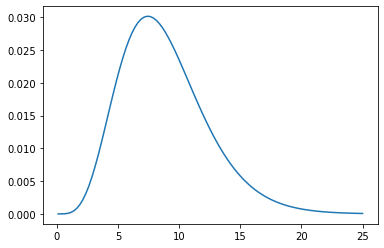

In [27]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
marginal_alpha.plot()
marginal_alpha.mean()

7.540121805297106

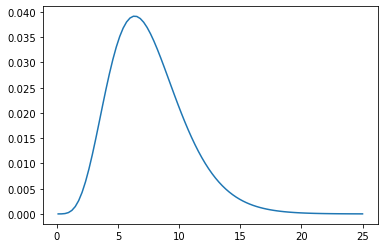

In [28]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
marginal_beta.plot()
marginal_beta.mean()

## One coin with PyMC

In [29]:
import pymc3 as pm

n = 250
with pm.Model() as model1:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    x1 = pm.Beta('x1', alpha, beta)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    pred = pm.sample_prior_predictive(1000)

Here's the graphical representation of the model.

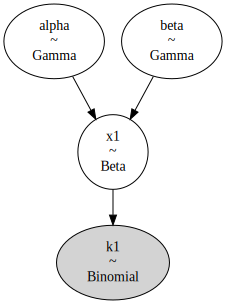

In [30]:
pm.model_to_graphviz(model1)

<AxesSubplot:xlabel='alpha'>

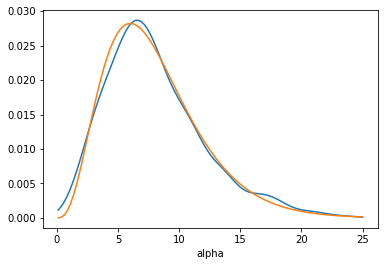

In [31]:
from utils import kde_from_sample

kde_from_sample(pred['alpha'], prior_alpha.qs).plot()
prior_alpha.plot()

<AxesSubplot:xlabel='beta'>

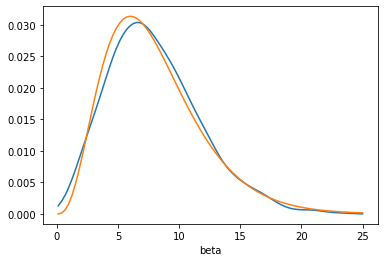

In [32]:
kde_from_sample(pred['beta'], prior_beta.qs).plot()
prior_beta.plot()

<AxesSubplot:>

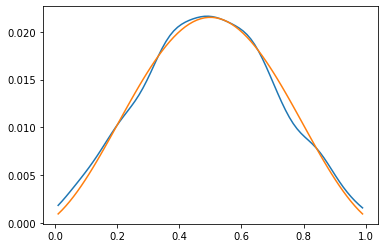

In [33]:
kde_from_sample(pred['x1'], prior_x.qs).plot()
prior_x.plot()

Now let's run the sampler.

In [34]:
with model1:
    trace1 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x1, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here are the posterior distributions for the two coins.

<AxesSubplot:>

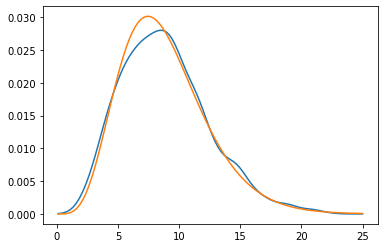

In [35]:
kde_from_sample(trace1['alpha'], marginal_alpha.qs).plot()
marginal_alpha.plot()

<AxesSubplot:>

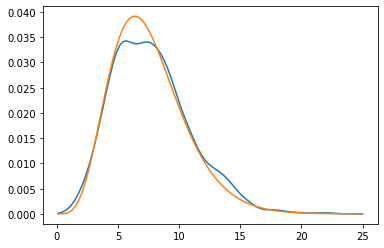

In [36]:
kde_from_sample(trace1['beta'], marginal_beta.qs).plot()
marginal_beta.plot()

<AxesSubplot:>

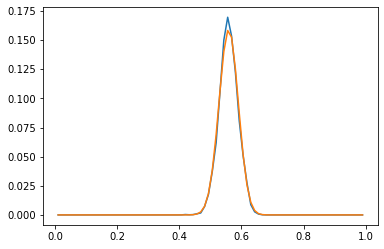

In [37]:
kde_from_sample(trace1['x1'], marginal_x.qs).plot()
marginal_x.plot()

## Two coins

In [38]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [39]:
posterior_hyper = get_hyper(posterior)
posterior_hyper.shape

(100, 90)

In [40]:
prior2 = make_prior(posterior_hyper, prior_alpha, prior_beta, xs)

In [41]:
data = 250, 110
posterior2 = update(prior2, data)

8.40113766033458

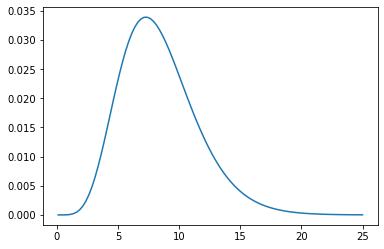

In [42]:
marginal_alpha2 = Pmf(marginal(posterior2, 0), prior_alpha.qs)
marginal_alpha2.plot()
marginal_alpha2.mean()

8.40114365112825

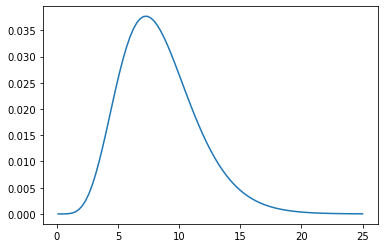

In [43]:
marginal_beta2 = Pmf(marginal(posterior2, 1), prior_beta.qs)
marginal_beta2.plot()
marginal_beta2.mean()

0.44375349844806367

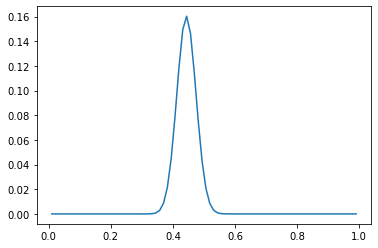

In [44]:
marginal_x2 = Pmf(marginal(posterior2, 2), xs)
marginal_x2.plot()
marginal_x2.mean()

## Two coins with PyMC

In [45]:
with pm.Model() as model2:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    x1 = pm.Beta('x1', alpha, beta)
    x2 = pm.Beta('x2', alpha, beta)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=110)

Here's the graph for this model.

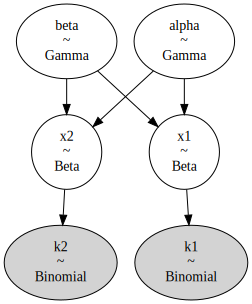

In [46]:
pm.model_to_graphviz(model2)



Let's run the sampler.

In [47]:
with model2:
    trace2 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


And here are the results.

(8.417392841927896, 8.40113766033458)

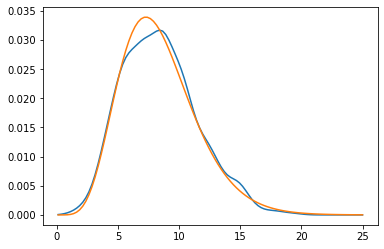

In [48]:
kde_from_sample(trace2['alpha'], marginal_alpha.qs).plot()
marginal_alpha2.plot()
trace2['alpha'].mean(), marginal_alpha2.mean()

(8.411990873606028, 8.40114365112825)

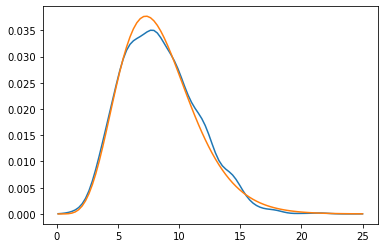

In [49]:
kde_from_sample(trace2['beta'], marginal_beta.qs).plot()
marginal_beta2.plot()
trace2['beta'].mean(), marginal_beta2.mean()

<AxesSubplot:>

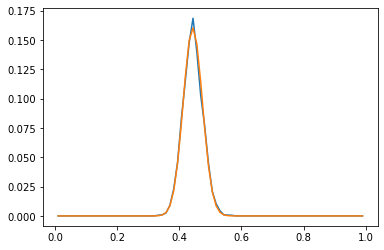

In [50]:
kde_from_sample(trace2['x2'], marginal_x.qs).plot()
marginal_x2.plot()

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [51]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [52]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [53]:
shuffled = df.sample(frac=1)

In [110]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

## Hospital Data with grid

In [111]:
alpha = 4
beta = 0.5

qs = np.linspace(0.1, 25, 100)
ps = gamma(alpha, scale=1/beta).pdf(qs)

prior_alpha = Pmf(ps, qs)
prior_alpha.normalize()

prior_alpha.index.name = 'alpha'

In [112]:
qs = np.linspace(0.1, 50, 90)
ps = gamma(alpha, scale=1/beta).pdf(qs)
prior_beta = Pmf(ps, qs)
prior_beta.normalize()

prior_beta.index.name = 'beta'
prior_beta.shape

(90,)

7.970910788849202

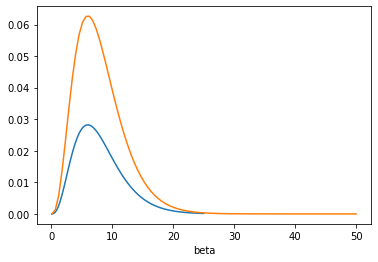

In [113]:
prior_alpha.plot()
prior_beta.plot()
prior_alpha.mean()

In [114]:
hyper = make_hyper(prior_alpha, prior_beta)
hyper.shape

(100, 90)

In [115]:
xs = np.linspace(0.01, 0.99, 80)
prior = make_prior(hyper, prior_alpha, prior_beta, xs)
prior.shape

(100, 90, 80)

In [116]:
for data in zip(data_ns, data_ks):
    print(data)
    posterior = update(prior, data)
    hyper = get_hyper(posterior)
    prior = make_prior(hyper, prior_alpha, prior_beta, xs)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)


2.097512983074644

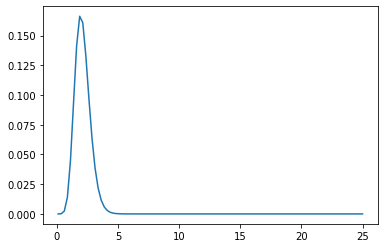

In [117]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
marginal_alpha.plot()
marginal_alpha.mean()

19.852137484809283

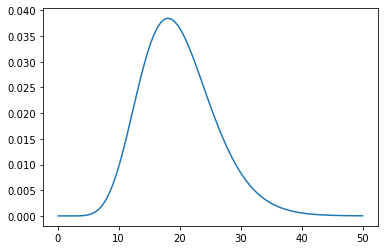

In [118]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
marginal_beta.plot()
marginal_beta.mean()

0.09707212033155088

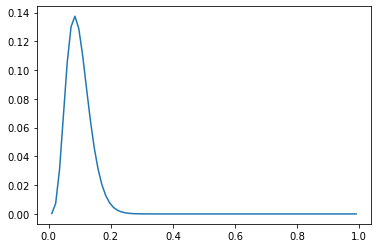

In [119]:
marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
marginal_x.plot()
marginal_x.mean()

## Hospital Data with PyMC

In [120]:
with pm.Model() as model4:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
    ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    trace4 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


Here's the graph representation of the model, showing that the observable is an array of 13 values.

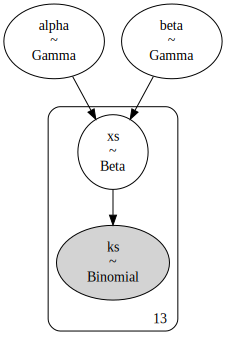

In [121]:
pm.model_to_graphviz(model4)

Here's the trace.

(2.1532329264501113, 2.097512983074644)

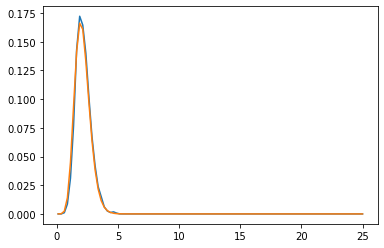

In [122]:
kde_from_sample(trace4['alpha'], marginal_alpha.qs).plot()
marginal_alpha.plot()
trace4['alpha'].mean(), marginal_alpha.mean()

(20.199394081479678, 19.852137484809283)

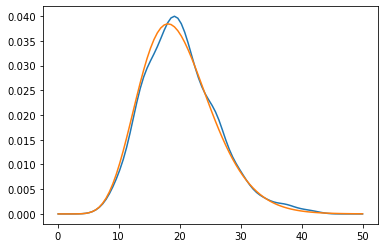

In [123]:
kde_from_sample(trace4['beta'], marginal_beta.qs).plot()
marginal_beta.plot()
trace4['beta'].mean(), marginal_beta.mean()

In [124]:
trace_xs = trace4['xs'].transpose()
trace_xs.shape

(13, 2000)

(0.09613920708285298, 0.09707212033155088)

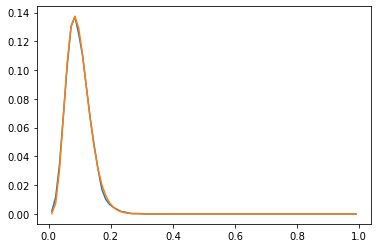

In [125]:
kde_from_sample(trace_xs[-1], marginal_x.qs).plot()
marginal_x.plot()
trace_xs[-1].mean(), marginal_x.mean()

## Getting the other xs

In [126]:
xs = np.linspace(0.01, 0.99, 80)
hyper = get_hyper(posterior)
post_all = make_prior(hyper, prior_alpha, prior_beta, xs)

In [127]:
def forget(posterior, data):
    n, ks = data
    X, K = np.meshgrid(xs, ks)
    like_x = binom.pmf(K, n, X).prod(axis=0)

    prior = posterior / like_x
    prior /= prior.sum()
    return prior

In [128]:
def get_marginal_x(post_all, data):
    prior = forget(post_all, data)
    hyper = get_hyper(prior)
    prior = make_prior(hyper, prior_alpha, prior_beta, xs)
    posterior = update(prior, data)
    marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
    return marginal_x

In [129]:
data = 270, 16
marginal_x = get_marginal_x(post_all, data)

/tmp/ipykernel_204426/2625109009.py:6: RuntimeWarning: divide by zero encountered in true_divide
  prior = posterior / like_x
/tmp/ipykernel_204426/2625109009.py:7: RuntimeWarning: invalid value encountered in true_divide
  prior /= prior.sum()


(0.041190203189248834, nan)

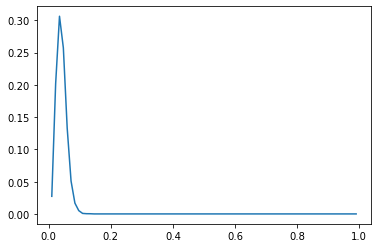

In [130]:
kde_from_sample(trace_xs[0], marginal_x.qs).plot()
marginal_x.plot()
trace_xs[0].mean(), marginal_x.mean()

## One at a time

In [133]:
likelihood = np.empty((len(df), len(xs)))

for i, row in df.iterrows():
    n = row['Cases']
    k = row['Deaths']
    likelihood[i] = binom.pmf(k, n, xs)

In [134]:
prod = likelihood.prod(axis=0)
prod.shape

(80,)

In [144]:
i = 3
all_but_one = prod / likelihood[i]

In [145]:
hyper_i = get_hyper(prior * all_but_one)

In [146]:
prior_i = make_prior(hyper_i, prior_alpha, prior_beta, xs)

In [147]:
data = df.loc[i, 'Cases'], df.loc[i, 'Deaths']
data

(84, 7)

In [148]:
posterior_i = update(prior_i, data)

In [149]:
marginal_alpha = Pmf(marginal(posterior_i, 0), prior_alpha.qs)
marginal_beta = Pmf(marginal(posterior_i, 1), prior_beta.qs)
marginal_x = Pmf(marginal(posterior_i, 2), prior_x.qs)

(2.1532329264501113, 2.2118989111174576)

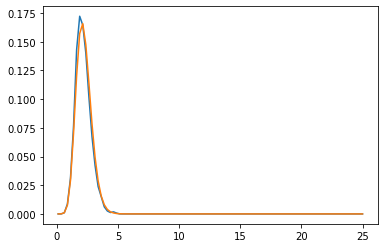

In [150]:
kde_from_sample(trace4['alpha'], marginal_alpha.qs).plot()
marginal_alpha.plot()
trace4['alpha'].mean(), marginal_alpha.mean()

(20.199394081479678, 21.347689380761715)

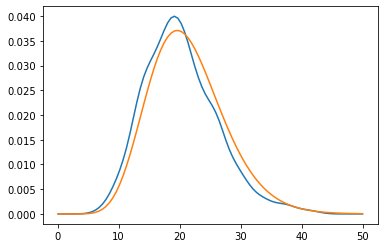

In [151]:
kde_from_sample(trace4['beta'], marginal_beta.qs).plot()
marginal_beta.plot()
trace4['beta'].mean(), marginal_beta.mean()

(0.08564261017162843, 0.08568040914334583)

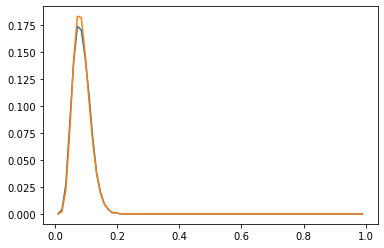

In [153]:
kde_from_sample(trace_xs[i], marginal_x.qs).plot()
marginal_x.plot()
trace_xs[i].mean(), marginal_x.mean()